<a href="https://colab.research.google.com/github/ahmabboud/Pizza-Coocking-Level-Recognition/blob/main/Pizza_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Possible Augmentations required:

* Masking out background
* Creating mask and adding to simulate oven light
* Decreasing brightness
* Increasing saturation

In [ ]:
!cp -r drive/My\ Drive/datasets/pizza_doneness .

In [ ]:
from fastai.vision import *

In [ ]:
imgs = Path('pizza_doneness/imgs').ls()

In [ ]:
from PIL import Image, ImageDraw, ImageFilter, ImageEnhance
import cv2
import numpy as np
import time
from matplotlib import pyplot as plt
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color

In [ ]:
#function to obtain coefficients required for perspective transform
def find_coeffs(source_coords, target_coords):
    matrix = []
    for s, t in zip(source_coords, target_coords):
        matrix.append([t[0], t[1], 1, 0, 0, 0, -s[0]*t[0], -s[0]*t[1]])
        matrix.append([0, 0, 0, t[0], t[1], 1, -s[1]*t[0], -s[1]*t[1]])
    A = np.matrix(matrix, dtype=np.float)
    B = np.array(source_coords).reshape(8)
    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res).reshape(8)

In [ ]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax
def invertList(input_list): 
   input_list.reverse()
   return input_list
def circle_points(resolution, center, radius):
    """
    Generate points which define a circle on an image.Centre refers to the centre of the circle
    """   
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T
def rect_points(resolution ,shape):
    resolution = int(resolution/2)
    width_points_n = int(resolution*shape[1]/(shape[1]+shape[0]))
    height_points_n = resolution-width_points_n
    width_points = list(np.linspace(0,shape[1], width_points_n))
    height_points = list(np.linspace(0, shape[0], height_points_n))
    return np.array([width_points + [shape[1]]*len(height_points) + invertList(width_points) + [1]* len(height_points),
     [1]*len(width_points) + height_points + [shape[0]]*len(width_points) + invertList(height_points)]).T

# Exclude last point because a closed path should not have duplicate points

In [ ]:
img_paths = [str(img_pth) for img_pth in imgs]

In [ ]:
img_path.split('/')[-1]

'gan_02209.jpg'

gan_05324.jpg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  # This is added back by InteractiveShellApp.init_path()


gan_06726.jpg
gan_02813.jpg
2510.jpeg
gan_04235.jpg


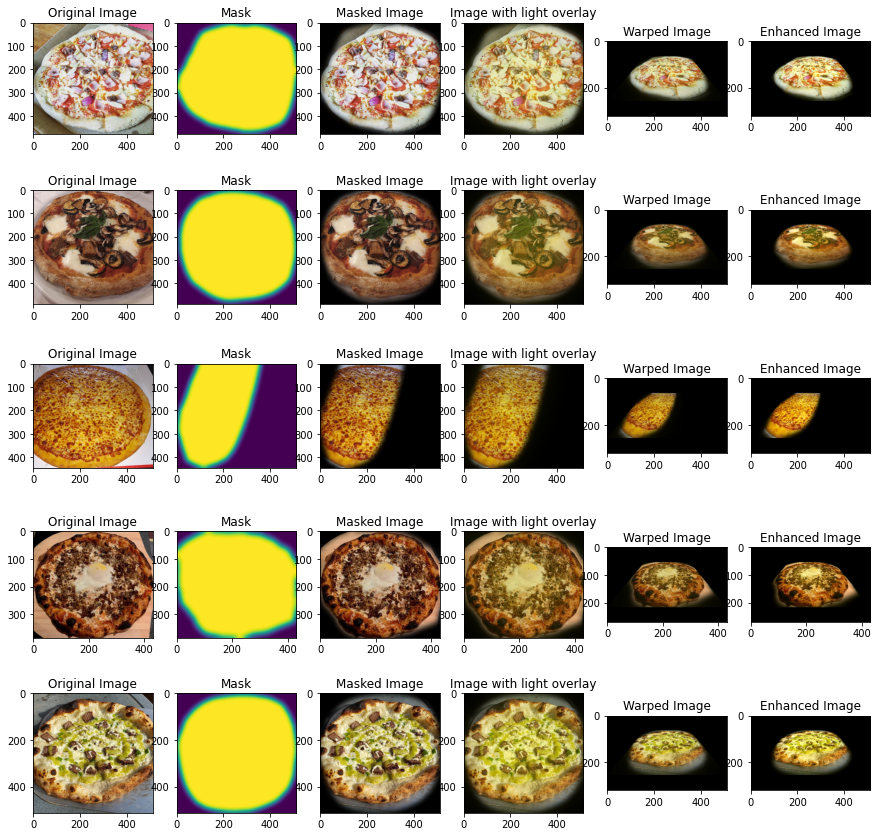

In [ ]:
img_pths = [str(imgs[i]) for i in np.random.randint(0,len(imgs),5)]
plt.figure(figsize=(15,15))
for i in range(5):
  img_path = img_pths[i]
  filename = img_path.split('/')[-1]
  print(filename)
  img = io.imread(img_path)
  pil_img = Image.fromarray(img)
  image_gray = color.rgb2gray(img) 
  points = rect_points(400, img.shape[:2])[:-1]
  seg_bounds = seg.active_contour(image_gray, points, alpha=0.14, beta=0.4)
  base_image = Image.new("RGB", pil_img.size, (0,0,0))
  light_overlay = Image.new("RGBA", pil_img.size, (0,0,0,0))
  mask = Image.new("L", pil_img.size, 0)
  draw_mask = ImageDraw.Draw(mask)
  draw_overlay = ImageDraw.Draw(light_overlay)
  draw_overlay.polygon([tuple(i) for i in seg_bounds], fill=(255,255,0,60))
  draw_mask.polygon([tuple(i) for i in seg_bounds], fill=255)
  mask = mask.filter(ImageFilter.GaussianBlur(10))
  light_overlay = light_overlay.filter(ImageFilter.GaussianBlur(80))
  plt.subplot(5,6,i*6+1),plt.imshow(pil_img)
  plt.title('Original Image')
  plt.subplot(5,6,i*6+2),plt.imshow(mask)
  plt.title('Mask')
  masked_img = Image.composite(pil_img,base_image,mask)
  plt.subplot(5,6,i*6+3),plt.imshow(masked_img)
  plt.title('Masked Image')
  overlayed_img = Image.alpha_composite(masked_img.convert("RGBA"), light_overlay)
  plt.subplot(5,6,i*6+4),plt.imshow(overlayed_img)
  plt.title('Image with light overlay')
  width = pil_img.width
  height = pil_img.height

  coeffs = find_coeffs(
          [(0, 0), (width, 0), (width, height), (0, height)],
          [(width*5/16, width/8), (width*11/16, width/8), (width, width/2), (0, width/2)])
  tfimg = overlayed_img.transform((int(width), int(width*5/8)), Image.PERSPECTIVE, coeffs,
          Image.BICUBIC).convert("RGB")
  plt.subplot(5,6,i*6+5),plt.imshow(tfimg)
  plt.title('Warped Image')
  en_img = ImageEnhance.Contrast(ImageEnhance.Brightness(tfimg).enhance(0.85)).enhance(1.4)
  plt.subplot(5,6,i*6+6),plt.imshow(en_img)
  plt.title('Enhanced Image')

plt.savefig('pizza_augmentations.png')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  """


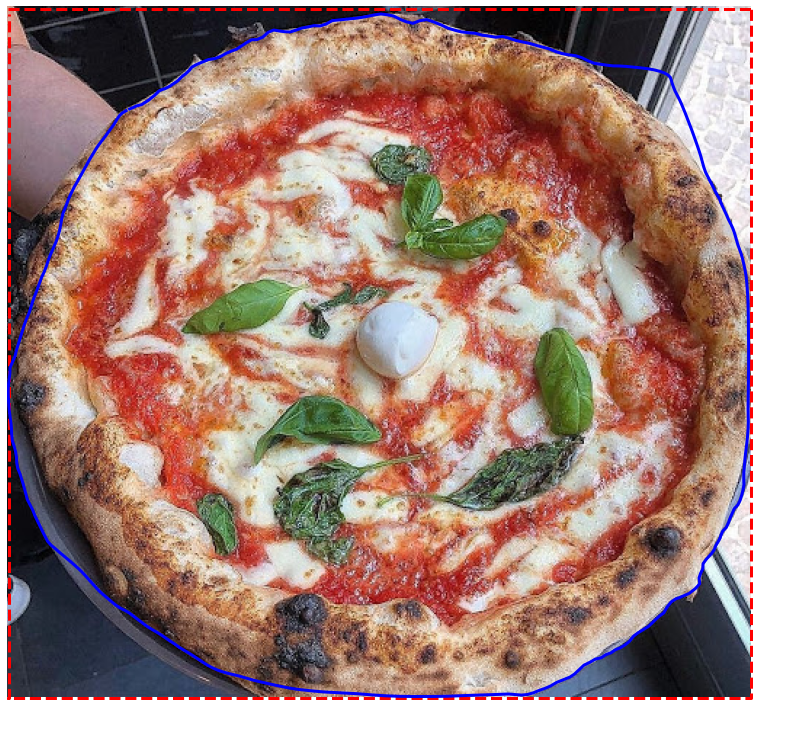

In [ ]:
img_pths = [str(imgs[i]) for i in np.random.randint(0,len(imgs),5)]
image = io.imread(img_pths[0])
image_gray = color.rgb2gray(image) 
points = rect_points(400, image.shape[:2])[:-1]
snake = seg.active_contour(image_gray, points, alpha=0.14, beta=0.4)
fig, ax = image_show(image)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

In [ ]:
def augment_images(img_path):
  filename = img_path.split('/')[-1]
  img = io.imread(img_path)
  pil_img = Image.fromarray(img)
  image_gray = color.rgb2gray(img) 
  points = rect_points(400, img.shape[:2])[:-1]
  seg_bounds = seg.active_contour(image_gray, points, alpha=0.14, beta=0.4)
  base_image = Image.new("RGB", pil_img.size, (0,0,0))
  light_overlay = Image.new("RGBA", pil_img.size, (0,0,0,0))
  mask = Image.new("L", pil_img.size, 0)
  draw_mask = ImageDraw.Draw(mask)
  draw_overlay = ImageDraw.Draw(light_overlay)
  draw_overlay.polygon([tuple(i) for i in seg_bounds], fill=(255,255,0,60))
  draw_mask.polygon([tuple(i) for i in seg_bounds], fill=255)
  mask = mask.filter(ImageFilter.GaussianBlur(10))
  light_overlay = light_overlay.filter(ImageFilter.GaussianBlur(80))
  masked_img = Image.composite(pil_img,base_image,mask)
  overlayed_img = Image.alpha_composite(masked_img.convert("RGBA"), light_overlay)
  width = pil_img.width
  height = pil_img.height
  coeffs = find_coeffs(
          [(0, 0), (width, 0), (width, height), (0, height)],
          [(width*5/16, width/8), (width*11/16, width/8), (width, width/2), (0, width/2)])
  tfimg = overlayed_img.transform((int(width), int(width*5/8)), Image.PERSPECTIVE, coeffs,
          Image.BICUBIC).convert("RGB")
  final_img = ImageEnhance.Contrast(ImageEnhance.Brightness(tfimg).enhance(0.85)).enhance(1.4)

  output = 'pizza_augmented/imgs/'+filename
  print('Saving image to {}'.format(output))
  final_img.save(output)

In [ ]:
import concurrent.futures

In [ ]:
with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
  executor.map(augment_images, img_paths)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `co

Saving image to pizza_augmented/imgs/froz275.jpg
Saving image to pizza_augmented/imgs/gan_02686.jpg
Saving image to pizza_augmented/imgs/gan_06689.jpg
Saving image to pizza_augmented/imgs/2137.jpg
Saving image to pizza_augmented/imgs/gan_01568.jpg
Saving image to pizza_augmented/imgs/gan_02555.jpg
Saving image to pizza_augmented/imgs/gan_08113.jpg
Saving image to pizza_augmented/imgs/2786.jpg
Saving image to pizza_augmented/imgs/gan_01895.jpg
Saving image to pizza_augmented/imgs/gan_01332.jpg
Saving image to pizza_augmented/imgs/gan_00813.jpg
Saving image to pizza_augmented/imgs/gan_01868.jpg
Saving image to pizza_augmented/imgs/gan_04740.jpg
Saving image to pizza_augmented/imgs/gan_05018.jpg
Saving image to pizza_augmented/imgs/0381.jpg
Saving image to pizza_augmented/imgs/gan_03161.jpg
Saving image to pizza_augmented/imgs/gan_06053.jpg
Saving image to pizza_augmented/imgs/1937.jpg
Saving image to pizza_augmented/imgs/gan_08096.jpg
Saving image to pizza_augmented/imgs/3899.jpg
Saving 

In [ ]:
!tar -cf pizza_aug.tar pizza_augmented/

In [ ]:
!cp pizza_aug.tar drive/My\ Drive/